# Clustering

Clustering techniques are unsupervised learning algorithms that try to group unlabelled data into "clusters", using the (typically spatial) structure of the data itself. It has many [applications](https://en.wikipedia.org/wiki/Cluster_analysis#Applications).

The easiest way to demonstrate how clustering works is to simply generate some data and show them in action. We'll start by importing the libraries we'll be using today.

In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Create data

In [3]:
n_clusters= 6
n_samples =250

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [4]:
centroids = torch.rand(n_clusters, 2)*70-35

In [5]:
centroids

tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551]])

In [6]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [7]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [8]:
slices = [sample(c) for c in centroids]

`torch.cat` - concatenates given sequence.\
`torch.cat()` can be seen as an inverse operation for `torch.split()` and `torch.chunk()`.

In [9]:
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [10]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker="x", color='m', mew=2)

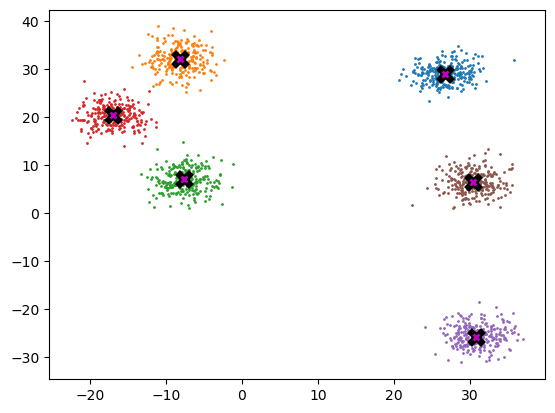

In [11]:
plot_data(centroids, data, n_samples)

## Mean shift

Most people that have come across clustering algorithms have learnt about **k-means**. Mean shift clustering is a newer and less well-known approach, but it has some important advantages:
* It doesn't require selecting the number of clusters in advance, but instead just requires a **bandwidth** to be specified, which can be easily chosen automatically
* It can handle clusters of any shape, whereas k-means (without using special extensions) requires that clusters be roughly ball shaped.

The algorithm is as follows:
* For each data point `x` in the sample `X`, find the distance between that point `x` and every other point in `X`
* Create weights for each point in `X` by using the **Gaussian kernel** of that point's distance to `x`
    * This weighting approach penalizes points further away from `x`
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update `x` as the weighted average of all other points in `X`, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

In [12]:
midp = data.mean(0)
midp

tensor([ 9.222, 11.604])

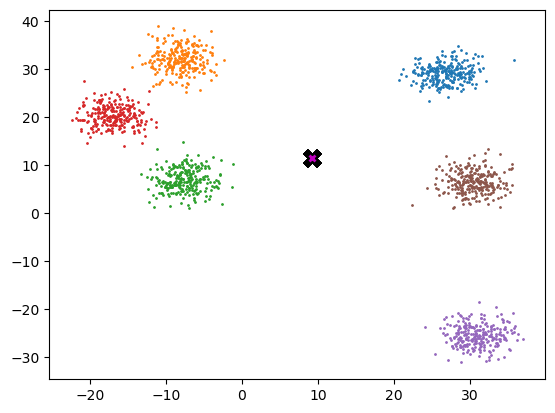

In [13]:
plot_data([midp]*6, data, n_samples)

So here's the definition of the gaussian kernel, which you may remember from high school...
 This person at the science march certainly remembered!

<img src="http://i.imgur.com/nijQLHw.jpg" width=400>

In [14]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

`troch.linespace(start,end,step)` - Creates a one-dimensional tensor of size `steps` whose values are evenly spaced from `start` to `end`, inclusive
* start (float) – the starting value for the set of points
* end (float) – the ending value for the set of points
* steps (int) – size of the constructed tensor

In [15]:
torch.linspace(0,10,11)

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [16]:
def plot_func(f):
    x = torch.linspace(0,10,100)
    plt.plot(x, f(x))

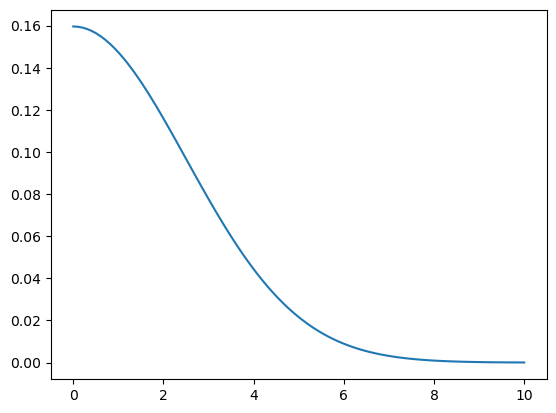

In [17]:
plot_func(partial(gaussian, bw=2.5))

the `partial` function is a higher-order function that allows you to create a new function by "partial" application of an existing function. In other words, it lets you fix some of the arguments of a function and create a new function with fewer arguments.

In [18]:
partial

functools.partial

In our implementation, we choose the bandwidth to be 2.5. 

One easy way to choose bandwidth is to find which bandwidth covers one third of the data.

In [19]:
def tri(d, i): return (-d+i).clamp_min(0)/i

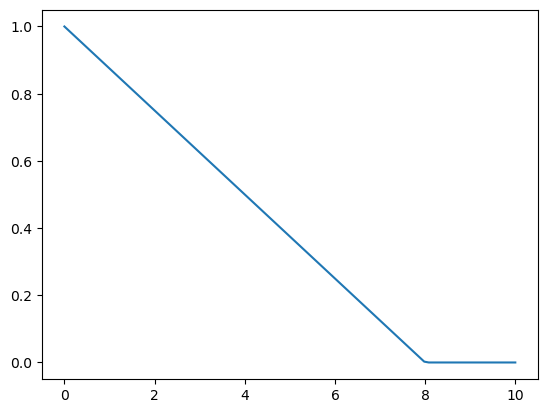

In [20]:
plot_func(partial(tri, i=8))

In [21]:
X = data.clone()
x = data[0]

In [22]:
x,X[0]

(tensor([26.204, 26.349]), tensor([26.204, 26.349]))

In [23]:
x.shape, X.shape, x[None].shape

(torch.Size([2]), torch.Size([1500, 2]), torch.Size([1, 2]))

In [24]:
(x[None]-X)[:8]

tensor([[ 0.000,  0.000],
        [ 0.513, -3.865],
        [-4.227, -2.345],
        [ 0.557, -3.685],
        [-5.033, -3.745],
        [-4.073, -0.638],
        [-3.415, -5.601],
        [-1.920, -5.686]])

In [25]:
(x-X)[:8].shape

torch.Size([8, 2])

In [26]:
(x-X)**2

tensor([[    0.000,     0.000],
        [    0.263,    14.936],
        [   17.871,     5.498],
        ...,
        [   20.869,   289.860],
        [    9.926,   501.266],
        [   24.641,   442.675]])

In [27]:
# rewrite using torch.einsum
from torch import einsum
d = torch.einsum('ij,ij -> i',x-X,x-X).sqrt()
d[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

In [28]:
dist = ((x-X)**2).sum(1).sqrt()
dist[:8]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002])

In [29]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.047,     0.025,  ...,     0.000,     0.000,     0.000])

In [30]:
weight.shape,X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [31]:
weight[:,None].shape

torch.Size([1500, 1])

In [32]:
weight[:,None]*X

tensor([[    4.182,     4.205],
        [    1.215,     1.429],
        [    0.749,     0.706],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [33]:
def one_update(X):
    for i, x in enumerate(X):
        # Here we calculate the distance for each point x
        #dist = torch.einsum('ij,ij -> i',x-X,x-X).sqrt() # IS SLOWER
        dist = torch.sqrt(((x-X)**2).sum(1)) # OLD FORMULA
#         weight = gaussian(dist, 2.5)
        weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [34]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [35]:
%time X=meanshift(data)

CPU times: user 1.07 s, sys: 11.6 ms, total: 1.08 s
Wall time: 816 ms


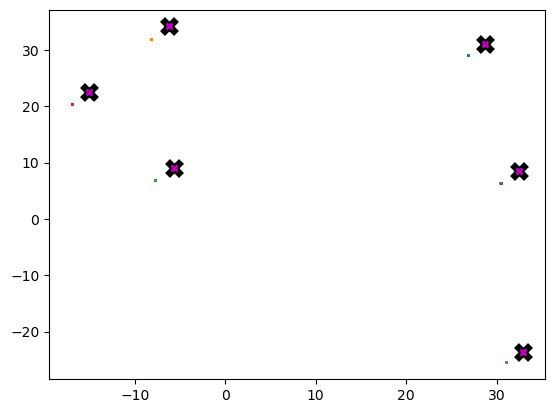

In [36]:
plot_data(centroids+2, X, n_samples)

## Animation

In [37]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [38]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [39]:
# create your animation
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=300,repeat=False)
plt.close()
HTML(ani.to_jshtml())

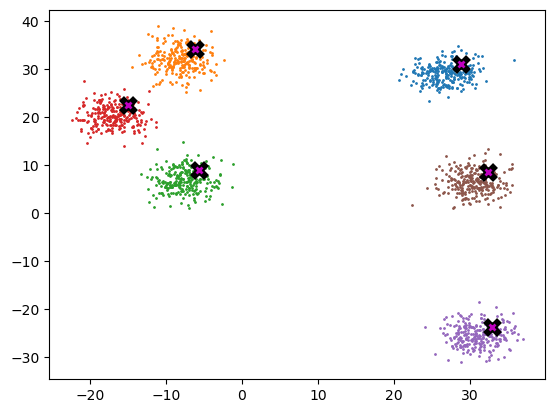

In [40]:
plot_data(centroids+2, data, n_samples)

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [41]:
bs=5 #5 # Will try later on n_batch_cluser ~~ 6
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

In [42]:
X[-6:,None]

tensor([[[30.164,  9.484]],

        [[29.829, 10.060]],

        [[29.688,  2.965]],

        [[30.772,  9.323]],

        [[29.354,  3.960]],

        [[31.168,  5.309]]])

In [43]:
(x[None] - X[-6:,None]).sum(2).shape

torch.Size([6, 5])

In [44]:
def dist_b(a,b): return (((a[None] - b[:,None])**2).sum(2)).sqrt()

In [45]:
dist_b(X, x)

tensor([[ 0.000,  3.899,  4.834,  ..., 17.628, 22.610, 21.617],
        [ 3.899,  0.000,  4.978,  ..., 21.499, 26.508, 25.500],
        [ 4.834,  4.978,  0.000,  ..., 19.373, 24.757, 23.396],
        [ 3.726,  0.185,  4.969,  ..., 21.335, 26.336, 25.333],
        [ 6.273,  5.547,  1.615,  ..., 20.775, 26.201, 24.785]])

In [46]:
dist_b(X, x).shape

torch.Size([5, 1500])

In [47]:
X[None,:]

tensor([[[26.204, 26.349],
         [25.691, 30.213],
         [30.431, 28.693],
         ...,
         [30.772,  9.323],
         [29.354,  3.960],
         [31.168,  5.309]]])

In [48]:
X[None,:].shape, x[:,None].shape, (X[None,:]-x[:,None]).shape

(torch.Size([1, 1500, 2]), torch.Size([5, 1, 2]), torch.Size([5, 1500, 2]))

In [49]:
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[    0.199,     0.030,     0.011,  ...,     0.000,     0.000,     0.000],
        [    0.030,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.011,     0.009,     0.199,  ...,     0.000,     0.000,     0.000],
        [    0.035,     0.199,     0.009,  ...,     0.000,     0.000,     0.000],
        [    0.001,     0.004,     0.144,  ...,     0.000,     0.000,     0.000]])

In [50]:
weight.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [51]:
weight[:,None].shape, X[None].shape

(torch.Size([5, 1, 1500]), torch.Size([1, 1500, 2]))

In [52]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [53]:
num

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [54]:
torch.einsum('ij,jk->ik', weight, X)

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [55]:
weight@X

tensor([[367.870, 386.231],
        [518.332, 588.680],
        [329.665, 330.782],
        [527.617, 598.217],
        [231.302, 234.155]])

In [56]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [57]:
num/div

tensor([[26.376, 27.692],
        [26.101, 29.643],
        [28.892, 28.990],
        [26.071, 29.559],
        [29.323, 29.685]])

In [58]:
def meanshift(data, bs=500, iter = 5):
    n = len(data) # n=1500
    X = data.clone() # X=data
    for it in range(iter):
        
        for i in range(0, n, bs): #step by batch size
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2.5)
#             weight = tri(dist_b(X, X[s]), 8)
            div = weight.sum(1, keepdim=True)
            X[s] = weight@X/div
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [59]:
torch.cuda.is_available()

True

In [60]:
data = data.cuda()

In [61]:
X = meanshift(data).cpu()

In [106]:
time = %timeit -n 5 -o meanshift(data, 1250).cpu()

6.49 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


In [63]:
X =  meanshift(data)

In [64]:
X[:10],data[:10]

(tensor([[26.758, 29.152],
         [26.758, 29.152],
         [26.758, 29.152],
         [26.758, 29.152],
         [26.758, 29.152],
         [26.758, 29.152],
         [26.758, 29.152],
         [26.758, 29.152],
         [26.758, 29.152],
         [26.758, 29.152]], device='cuda:0'),
 tensor([[26.204, 26.349],
         [25.691, 30.213],
         [30.431, 28.693],
         [25.647, 30.033],
         [31.236, 30.093],
         [30.276, 26.987],
         [29.619, 31.949],
         [28.124, 32.035],
         [24.275, 29.255],
         [21.578, 28.565]], device='cuda:0'))

Animation

In [65]:
def one_update(data,bs=500):
    n = len(data)
    for i in range(0,n,bs):
        s = slice(i,min(i+bs,n))
        weight = gaussian(dist_b(data, data[s]), 2.5)
        div = weight.sum(1, keepdim=True)
        X[s] = weight@X/div

In [66]:
X.cpu().numpy()

array([[26.757818, 29.151628],
       [26.757818, 29.151628],
       [26.757818, 29.151628],
       ...,
       [30.456202,  6.457344],
       [30.456202,  6.457344],
       [30.456202,  6.457344]], dtype=float32)

In [67]:
def do_one(d):
    if d:one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

X = data.clone()
X = X.cpu()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=300,repeat=False)
plt.close()
HTML(ani.to_jshtml())

# Homework

**Homework:** implement k-means clustering, dbscan, locality sensitive hashing, or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. Check if your version is faster than a pure python or CPU version.

Bonus: Implement it in APL too!

Super bonus: Invent a new meanshift algorithm which picks only the closest points, to avoid quadratic time.

Super super bonus: Publish a paper that describes it :D

In [68]:
data = data.cpu()

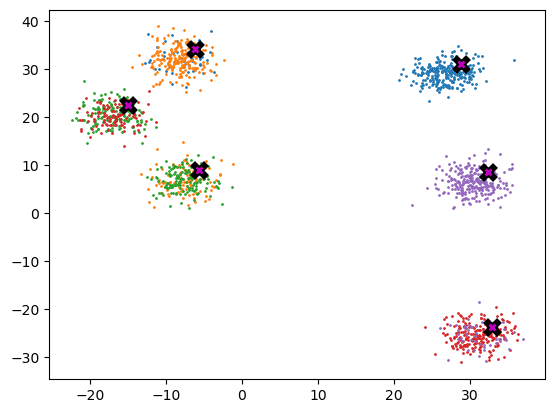

In [69]:
plot_data(centroids+2, data, 300)

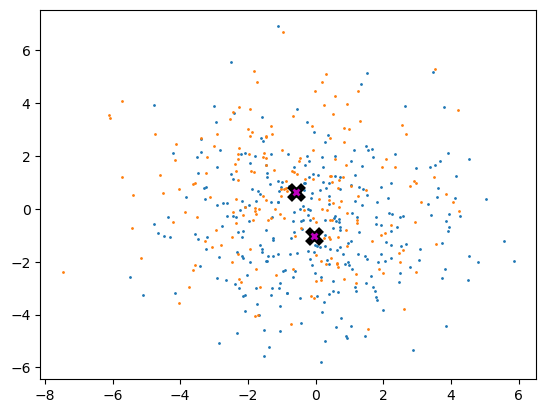

In [70]:
n_clusters = 2
cluster_center = torch.rand(n_clusters, 2)*5-2
data_points =  [sample(c) for c in cluster_center]
data_points = torch.cat(data_points)
# Now chose n_cluster random data_points and calculate distance from than to every other datapoint?
plot_data(cluster_center, data_points, 300)

How it works

In [71]:
centr = torch.rand(n_clusters, n_clusters)*data.max()-data.max()

In [72]:
data[:,None][0],centr[None,:][0]

(tensor([[26.204, 26.349]]),
 tensor([[-21.419, -26.425],
         [-10.721,  -5.249]]))

Operations

In [73]:
(data[:,None][0] - centr[None,:][0])

tensor([[47.623, 52.774],
        [36.925, 31.598]])

In [74]:
(data[:,None] - centr[None,:]).sum(dim=2)[0]

tensor([100.396,  68.523])

Adding in `sqrt` and `**2`

In [75]:
torch.sqrt(((data[:,None] - centr[None,:])**2).sum(dim=2))[0]

tensor([71.084, 48.599])

In [76]:
data[:,None].shape,

(torch.Size([1500, 1, 2]),)

### My first version of the algorythm

In [77]:
def k_mean_cluster(data, n_clusters=2,max_iters = 100):
    # Initialize the clusters and centroids
    clusters = [torch.tensor([]).cuda() for _ in range(n_clusters)]
    centroids = data[torch.randint(low=0, high=data.shape[0], size=(n_clusters,))]
    # OLD torch.rand(n_clusters, 2) * data.max() - data.max()

    for _ in range(max_iters):
        # Compute the distances between each data point and each centroid
        dists = torch.sqrt(((data[:, None] - centroids[None, :]) ** 2).sum(dim=2))

        # Assign each data point to the nearest centroid
        for n in range(data.shape[0]):
            m_val, m_idx = torch.min(dists[n], dim=0)
            clusters[m_idx] = torch.cat((clusters[m_idx], data[n].unsqueeze(0)), dim=0)

        # Check for empty clusters and assign a random data point to them
        for i in range(n_clusters):
            if clusters[i].shape[0] == 0:
                rand_idx = torch.randint(low=0, high=data.shape[0], size=(1,))
                clusters[i] = data[rand_idx]

        # Compute the new centroids
        n_centroids = torch.stack([cluster.mean(axis=0) for cluster in clusters])

        # Check for convergence
        if torch.max(torch.abs(centroids - n_centroids)) < 1e-5:
          break

        centroids = n_centroids

    return centroids

PyTorch's version of the algorythm

In [78]:
import torch

def k_means_clustering(data, k, max_iterations=100):
    # randomly initialize k centroids from the data
    centroids = data[torch.randperm(data.size()[0])[:k], :]

    for i in range(max_iterations):
        # calculate the distance between each data point and each centroid
        distances = torch.cdist(data, centroids)

        # assign each data point to the closest centroid
        cluster_labels = torch.argmin(distances, dim=1)

        # update the centroids by taking the mean of each cluster
        for j in range(k):
            centroids[j, :] = torch.mean(data[cluster_labels == j, :], dim=0)

    return centroids,cluster_labels

Data Gen

In [79]:
def gen_data(n_clusters=3, n_samples=250):
    centroids = torch.rand(n_clusters, 2)*70-35
    def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))
    slices = [sample(c) for c in centroids]
    data = torch.cat(slices)
    return data.cuda(),n_clusters
data,n = gen_data(4,300)

In [108]:
time = %time c_torch , b = k_means_clustering(data,4)

CPU times: user 59.4 ms, sys: 24 µs, total: 59.4 ms
Wall time: 58.8 ms


In [109]:
time = %time c = k_mean_cluster(data,n_clusters = 4)

CPU times: user 7.94 s, sys: 51.9 ms, total: 7.99 s
Wall time: 8.04 s


(None, None)

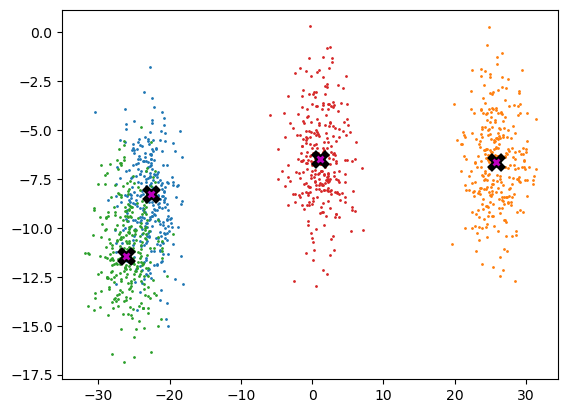

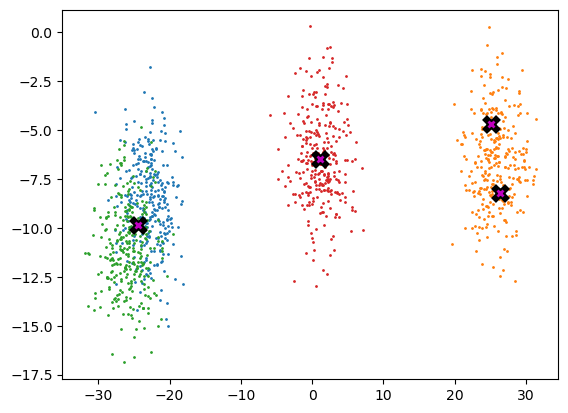

In [82]:
plot_data(c.cpu(), data.cpu(), 300),plot_data(c_torch.cpu(), data.cpu(), 300)

### Let's try to optimize `my` code

```
def k_mean_cluster(data, n_clusters=2,max_iters = 100):
    clusters = [torch.tensor([]).cuda() for _ in range(n_clusters)]
    centroids = data[torch.randint(low=0, high=data.shape[0], size=(n_clusters,))]
    
    for _ in range(max_iters):
        # Compute the distances between each data point and each centroid
        dists = torch.sqrt(((data[:, None] - centroids[None, :]) ** 2).sum(dim=2))

        # Assign each data point to the nearest centroid
        for n in range(data.shape[0]):
            m_val, m_idx = torch.min(dists[n], dim=0)
            clusters[m_idx] = torch.cat((clusters[m_idx], data[n].unsqueeze(0)), dim=0)

        # Check for empty clusters and assign a random data point to them
        for i in range(n_clusters):
            if clusters[i].shape[0] == 0:
                rand_idx = torch.randint(low=0, high=data.shape[0], size=(1,))
                clusters[i] = data[rand_idx]

        # Compute the new centroids
        n_centroids = torch.stack([cluster.mean(axis=0) for cluster in clusters])
```

First thing we see is 2 loops inside a main loop.\
First loop assigns each data point to the nearest centroid,\
Second one Check for empty clusters.

As we can see the pytorch version doesn't have to deal with empty clusters let's study the code and learn why.

In [83]:
def k_means_clustering(data, k, max_iterations=100):
    # randomly initialize k centroids from the data
    centroids = data[torch.randperm(data.size()[0])[:k], :]

    for i in range(max_iterations):
        # calculate the distance between each data point and each centroid
        distances = torch.cdist(data, centroids)

        # assign each data point to the closest centroid
        cluster_labels = torch.argmin(distances, dim=1)

        # update the centroids by taking the mean of each cluster
        for j in range(k):
            centroids[j, :] = torch.mean(data[cluster_labels == j, :], dim=0)

    return cluster_labels, centroids

In [84]:

data,n_clusters = gen_data(n_clusters=2, n_samples=250)


In [112]:
centroids_torch = data[torch.randperm(data.size()[0])[:n_clusters], :]
centroids_torch

tensor([[-19.641,  35.436],
        [ 11.771, -23.537]], device='cuda:0')

In [113]:
distances_torch = torch.cdist(data, centroids_torch)
distances_torch.shape

torch.Size([1200, 2])

In [87]:
torch.argmin(distances_torch,dim = 1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 

This is relly imporant line of code since it compares the values and also indexes them. \
Let's time pytorch version and mine.

In [110]:
time = %timeit torch.argmin(distances_torch,dim = 1)

8.32 µs ± 90.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [89]:
clusters = [torch.tensor([]).cuda() for _ in range(n_clusters)]

In [114]:
def f():
    for n in range(data.shape[0]):
        m_val, m_idx = torch.min(distances_torch[n], dim=0)
        clusters[m_idx] = torch.cat((clusters[m_idx], data[n].unsqueeze(0)), dim=0)
time = %timeit f()

82 ms ± 1.37 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


It is much slower, let's try improving it, without copying code\
First thing is that my code uses dim=0, and not dim=1 let's try it.

In [91]:
distances_torch[0]

tensor([29.022, 32.191], device='cuda:0')

If we want to used `dim = 1`, we cant use `distances_torch[0]` but `distances_torch`

In [92]:
torch.min(distances_torch, dim=1)

torch.return_types.min(
values=tensor([   29.022,    26.725,    25.411,    21.207,    25.743,    27.463,    31.854,    31.035,    29.316,    24.920,    28.640,    29.179,
           24.497,    27.853,    29.511,    23.087,    31.739,    26.912,    27.649,    27.245,    25.902,    23.383,    30.117,    27.993,
           27.577,    26.989,    25.548,    26.284,    25.495,    30.283,    24.374,    28.859,    26.829,    31.131,    25.715,    23.272,
           25.707,    26.916,    31.530,    26.122,    28.556,    28.537,    28.467,    27.663,    23.742,    30.299,    26.929,    26.418,
           27.403,    28.013,    27.363,    27.259,    24.661,    27.483,    27.267,    25.143,    21.972,    28.297,    27.241,    27.648,
           29.624,    25.127,    30.566,    25.438,    24.846,    28.415,    27.801,    30.654,    31.536,    22.906,    26.941,    26.011,
           26.773,    29.378,    21.556,    29.346,    27.835,    28.753,    26.682,    30.314,    30.080,    28.670,    27.060, 

`torch.min` return values and indexes in my code we did use both of them but this way we don't need to loop let's compare speed

In [115]:
def f_v1():
    m_val, m_idx = torch.min(distances_torch, dim=1)
    for n in range(data.shape[0]):
        clusters[m_idx[n]] = torch.cat((clusters[m_idx[n]], data[n].unsqueeze(0)), dim=0)
time = %timeit f_v1()

66 ms ± 3.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


It's already quite faster, but we still are stuck in the loop. \
Let's look at the second loop for now.

In [94]:
# Check for empty clusters and assign a random data point to them
def f_():
    for i in range(n_clusters):
        if clusters[i].shape[0] == 0:
            rand_idx = torch.randint(low=0, high=data.shape[0], size=(1,))
            clusters[i] = data[rand_idx]
# But first look if we even need to check with the new method
# We were creating n_centroids.
# But pytorch just updates them

# n_centroids = torch.stack([cluster.mean(axis=0) for cluster in clusters])

We were creating n_centroids.
But pytorch just updates them
```
# update the centroids by taking the mean of each cluster
for j in range(k):
    centroids[j, :] = torch.mean(data[cluster_labels == j, :], dim=0)
```

In [95]:
m_val, m_idx = torch.min(distances_torch, dim=1)

In [96]:
def update_centroids():
    for j in range(n_clusters):
        centroids[j,:] = torch.mean(data[m_idx == j, :],dim=0)

With this, we can also remove the check for convergence


In [97]:
def k_mean_cluster_new(data, n_clusters=2,max_iters = 100):
    # Initialize the clusters and centroids
    clusters = [torch.tensor([]).cuda() for _ in range(n_clusters)]
    centroids = data[torch.randint(low=0, high=data.shape[0], size=(n_clusters,))]
    # OLD torch.rand(n_clusters, 2) * data.max() - data.max()

    for _ in range(max_iters):
        # Compute the distances between each data point and each centroid
        dists = torch.sqrt(((data[:, None] - centroids[None, :]) ** 2).sum(dim=2))

        # Assign each data point to the nearest centroid
        m_val, m_idx = torch.min(dists, dim=1)
        for n in range(data.shape[0]):
            clusters[m_idx[n]] = torch.cat((clusters[m_idx[n]], data[n].unsqueeze(0)), dim=0)

        # Check for empty clusters and assign a random data point to them
        for i in range(n_clusters):
            if clusters[i].shape[0] == 0:
                rand_idx = torch.randint(low=0, high=data.shape[0], size=(1,))
                clusters[i] = data[rand_idx]

        # Compute the new centroids
        for j in range(n_clusters):
            centroids[j,:] = torch.mean(data[m_idx == j, :],dim=0)

    return centroids

In [116]:
time = %timeit k_mean_cluster_new(data=data,n_clusters=n)

50.6 ms ± 718 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [117]:
time = %timeit k_mean_cluster(data,n)

8.04 s ± 204 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Nice, it almost works twice as fast.

In [118]:
def k_mean_cluster_new(data, n_clusters=2,max_iters = 100):
    # Initialize the clusters and centroids
    clusters = [torch.tensor([]).cuda() for _ in range(n_clusters)]
    centroids = data[torch.randint(low=0, high=data.shape[0], size=(n_clusters,))]
    # OLD torch.rand(n_clusters, 2) * data.max() - data.max()

    for _ in range(max_iters):
        # Compute the distances between each data point and each centroid
        dists = torch.sqrt(((data[:, None] - centroids[None, :]) ** 2).sum(dim=2))

        # Assign each data point to the nearest centroid
        m_val, m_idx = torch.min(dists, dim=1)
        for n in range(data.shape[0]):
            clusters[m_idx[n]] = torch.cat((clusters[m_idx[n]], data[n].unsqueeze(0)), dim=0)

        # Compute the new centroids
        for j in range(n_clusters):
            centroids[j,:] = torch.mean(data[m_idx == j, :],dim=0)

    return centroids
time = %timeit k_mean_cluster_new(data,n)

5.48 s ± 87.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Nice it even works without, checking for empty clusters.\
Also, clusters are not being used in the above algorithm, so we can remove them.

In [119]:
def k_mean_cluster_new(data, n_clusters=2,max_iters = 100):

    centroids = data[torch.randint(low=0, high=data.shape[0], size=(n_clusters,))]
    # OLD torch.rand(n_clusters, 2) * data.max() - data.max()

    for _ in range(max_iters):
        # Compute the distances between each data point and each centroid
        dists = torch.sqrt(((data[:, None] - centroids[None, :]) ** 2).sum(dim=2))

        # Assign each data point to the nearest centroid
        m_val, m_idx = torch.min(dists, dim=1)

        # Compute the new centroids
        for j in range(n_clusters):
            centroids[j,:] = torch.mean(data[m_idx == j, :],dim=0)

    return centroids
time =  = %timeit -n 5 -o meanshift(data, 1250).cpu()%timeit k_mean_cluster_new(data,n)

51.3 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
